In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
sw_data=pd.read_csv("full_quarterly_data_set.csv")
sw_airports=np.unique('-'.join(sw_data.loc[sw_data['year']==2019]['citypair'].tolist()).split('-'))

In [25]:
print(sw_airports)
print(len(sw_airports))

['ABQ' 'ALB' 'AMA' 'ATL' 'AUS' 'BDL' 'BHM' 'BNA' 'BOI' 'BOS' 'BUF' 'BUR'
 'BWI' 'CHS' 'CLE' 'CLT' 'CMH' 'CRP' 'CVG' 'DAL' 'DCA' 'DEN' 'DSM' 'DTW'
 'ECP' 'ELP' 'EWR' 'FLL' 'GEG' 'GRR' 'GSP' 'HOU' 'HRL' 'IAD' 'ICT' 'IND'
 'ISP' 'JAX' 'LAS' 'LAX' 'LBB' 'LGA' 'LGB' 'LIT' 'MAF' 'MCI' 'MCO' 'MDW'
 'MEM' 'MHT' 'MKE' 'MSP' 'MSY' 'OAK' 'OKC' 'OMA' 'ONT' 'ORF' 'PBI' 'PDX'
 'PHL' 'PHX' 'PIT' 'PNS' 'PVD' 'PWM' 'RDU' 'RIC' 'RNO' 'ROC' 'RSW' 'SAN'
 'SAT' 'SDF' 'SEA' 'SFO' 'SJC' 'SJU' 'SLC' 'SMF' 'SNA' 'STL' 'TPA' 'TUL'
 'TUS']
85


In [28]:
geographic_data=pd.read_csv("airports.csv")
geographic_data.loc[geographic_data['IATA'].isin(sw_airports)]

,IATA,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABQ,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194
2,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
3,AUS,Austin-Bergstrom International,Austin,TX,USA,30.194533,-97.669872
4,BDL,Bradley International,Windsor Locks,CT,USA,41.938874,-72.683228
5,BHM,Birmingham International,Birmingham,AL,USA,33.562943,-86.753550
...,...,...,...,...,...,...,...
238,MAF,Midland International,Midland,TX,USA,31.942528,-102.201914
247,MHT,Manchester,Manchester,NH,USA,42.934516,-71.437056
279,PNS,Pensacola Regional,Pensacola,FL,USA,30.473306,-87.187444
286,PWM,Portland International Jetport,Portland,ME,USA,43.646167,-70.308750


In [30]:
for sw in sw_airports:
    if sw not in geographic_data['IATA'].tolist():
        print(sw)

ECP


In [34]:
np.radians([[-33.5786,12.6791],[54.8971,-76.9810]])

array([[-0.58605713,  0.22129204],
       [ 0.95813514, -1.34357191]])

In [46]:
sw_airports_location=geographic_data.loc[geographic_data['IATA'].isin(sw_airports)][['IATA','LATITUDE','LONGITUDE']]
sw_airports_location

,IATA,LATITUDE,LONGITUDE
0,ABQ,35.040222,-106.609194
2,ATL,33.640444,-84.426944
3,AUS,30.194533,-97.669872
4,BDL,41.938874,-72.683228
5,BHM,33.562943,-86.753550
...,...,...,...
238,MAF,31.942528,-102.201914
247,MHT,42.934516,-71.437056
279,PNS,30.473306,-87.187444
286,PWM,43.646167,-70.308750


In [47]:
ECP_row={'IATA':'ECP','LATITUDE':30.352934,'LONGITUDE':-85.79427}
sw_airports_location=sw_airports_location.append(ECP_row,ignore_index=True)
sw_airports_location

C:\Users\Nihaar\AppData\Local\Temp\ipykernel_17156\508472454.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sw_airports_location=sw_airports_location.append(ECP_row,ignore_index=True)


,IATA,LATITUDE,LONGITUDE
0,ABQ,35.040222,-106.609194
1,ATL,33.640444,-84.426944
2,AUS,30.194533,-97.669872
3,BDL,41.938874,-72.683228
4,BHM,33.562943,-86.753550
...,...,...,...
80,MHT,42.934516,-71.437056
81,PNS,30.473306,-87.187444
82,PWM,43.646167,-70.308750
83,ROC,43.118866,-77.672384


In [35]:
#Function that calculates the haversine distance between two sets of coordinates
from sklearn.metrics.pairwise import haversine_distances
def haversine(x,y):
    R=6371 #Radius of Earth in KM
    x_rd=np.radians(x)
    y_rd=np.radians(y)
    d=R*haversine_distances([x_rd,y_rd]) #Haversine Distance
    return d

In [294]:
coordinates=sw_airports_location.values[:,1:]
codes=sw_airports_location.values[:,0]
weights=np.ones(85)
no_of_clusters=7
distance_matrix=np.zeros((codes.size,no_of_clusters))
counter=0

In [299]:
#Randomly chooses k points that serve as the initial cluster centres
idx=np.random.choice(codes.size,no_of_clusters,replace=False)
new_centres=list((codes[idx]))
old_centres=[]
centres_coords=coordinates[idx,:]   

In [301]:
for i in range(10):
    
    #Calculates the distance between each point and every centre and stores in the data matrix
    k,l=0,0
    for i in coordinates:
        for j in centres_coords:
            distance_matrix[k][l]=haversine(list(i),list(j))[0][1]
            l=l+1
        l=0
        k=k+1
        
    #Assigns each point to a cluster
    #Labels each point with the cluster centre closest to it and adds it as an attribute to the dataframe
    labels=[]
    for i in distance_matrix:
        i=list(i)
        labels.append(new_centres[i.index(min(i))])
    sw_airports_location['LABELS']=labels
    
    #For each cluster, finds out the weighted average of all latitudes and longitudes (Virtual point)
    #Makes that point the cluster centre whose haversine distance from the virtual point is least
    #Assigns all new cluster centres coordinates by replacing old ones
    centre_coords=[]
    for centres in np.unique(labels):
        a=sw_airports_location.loc[sw_airports_location['LABELS']==centres][['LATITUDE','LONGITUDE']].values
        j=np.average(a,axis=0)
        min_distance=np.inf
        for i in a:
            dd=haversine(list(i),list(j))[0][1]
            if (dd<min_distance):
                min_i=i
                min_distance=dd
        centre_coords.append(list(min_i))
        
    #The cluster centres of the previous iteration become old clusters now
    old_centres=new_centres
    #Finding the corresponding airports to the newly found cluster centre coordinates
    new_centres=[]
    for i in centre_coords:
        new_centres.append(sw_airports_location.iloc[sw_airports_location.index[(sw_airports_location['LATITUDE']==i[0]) & 
                                                         (sw_airports_location['LONGITUDE']==i[1])].tolist()[0]]['IATA'])
    
    print('Old Centre =',old_centres)
    print('New Centre =',new_centres)

TypeError: ufunc 'radians' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

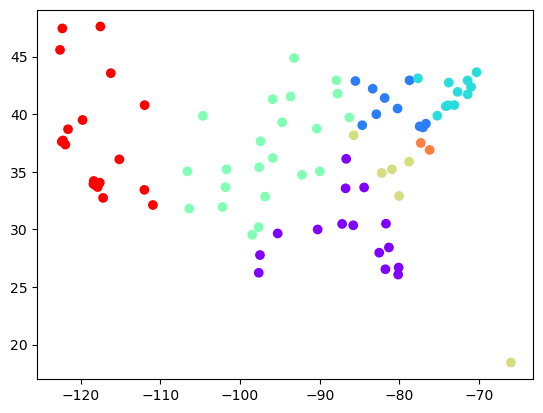

In [284]:
#Plotting the clusters
plt.scatter(coordinates[:,1],coordinates[:,0],c=pd.Categorical(labels).codes,cmap=plt.cm.rainbow)

array([6, 1, 5, 2, 0, 0, 2, 2, 6, 2, 1, 0, 1, 0, 0, 3, 2, 3, 0, 6, 2, 5,
       5, 2, 0, 1, 6, 6, 2, 0, 3, 5, 4, 0, 4, 4, 5, 6, 3, 3, 6, 2, 5, 6,
       2, 6, 2, 2, 1, 2, 6, 5, 6, 5, 0, 6, 6, 6, 1, 6, 6, 6, 3, 5, 3, 6,
       2, 3, 6, 5, 3, 6, 4, 1, 5, 3, 2, 3, 6, 3, 2, 5, 2, 2, 5],
      dtype=int8)

In [243]:
sw_airports_location.loc[sw_airports_location['IATA']=='SDF']

,IATA,LATITUDE,LONGITUDE,LABELS
54,SDF,38.174389,-85.736,BNA


In [242]:
sw_airports_location.loc[sw_airports_location['LABELS']=='BNA']

,IATA,LATITUDE,LONGITUDE,LABELS
4,BHM,33.562943,-86.753550,BNA
5,BNA,36.124477,-86.678182,BNA
11,CLE,41.410894,-81.849397,BNA
13,CMH,39.997985,-82.891883,BNA
14,CVG,39.046143,-84.662172,BNA
18,DTW,42.212059,-83.348836,BNA
24,IND,39.717329,-86.294384,BNA
29,LIT,34.729396,-92.224246,BNA
33,MEM,35.042417,-89.976667,BNA
54,SDF,38.174389,-85.736000,BNA
